In [1]:
import json
import pandas as pd
import plotly.express as px


In [2]:
train_df = pd.read_csv("train_df.csv", index_col=0)
image_performance = None

for training in ["baseline", "clicktrained"]:
    for testing in ["default", "without_clicks", "with_clicks"]:
        if training == "baseline" and testing != "default":
            continue
        if training == "clicktrained" and testing == "default":
            continue
        for model in ["mit-b3", "mit-b4", "mit-b5"]:
            model_path = "model_" + training + "_" + model
            if training == "baseline":
                df = pd.read_csv(model_path + "/image_perf_df.csv")
                df.rename(columns={df.columns[0]: "image_id"}, inplace=True)
            else:
                # this part was not summarized in training :(
                # let's summarize it now
                predictions_path = model_path + "/predictions_clicks_train"
                if testing == "with_clicks":
                    predictions_path += "_test"
                performance_metrics_file = (
                    predictions_path + "/performance_metrics.json"
                )
                with open(performance_metrics_file, "r") as pfile:
                    performance_metrics = json.load(pfile)
                    performance_metrics = {
                        int(k): v for k, v in performance_metrics.items()
                    }

                df = train_df[["dataset", "tumor", "dataset_tumor"]].copy()
                df["iou"] = [
                    performance_metrics[x]["per_category_niou"][1]
                    for x in range(len(performance_metrics.keys()))
                ]
                df["dice"] = [
                    performance_metrics[x]["per_category_dice"][1]
                    for x in range(len(performance_metrics.keys()))
                ]
                df["precision"] = [
                    performance_metrics[x]["per_category_precision"][1]
                    for x in range(len(performance_metrics.keys()))
                ]
                df["recall"] = [
                    performance_metrics[x]["per_category_recall"][1]
                    for x in range(len(performance_metrics.keys()))
                ]
                df["area_label"] = [
                    performance_metrics[x]["total_area_label"][1]
                    for x in range(len(performance_metrics.keys()))
                ]
                df["area_pred"] = [
                    performance_metrics[x]["total_area_pred"][1]
                    for x in range(len(performance_metrics.keys()))
                ]
                df.reset_index(inplace=True, names=["image_id"])

            df["training"] = [training] * df.shape[0]
            df["testing"] = [testing] * df.shape[0]
            df["model"] = [model] * df.shape[0]

            if image_performance is None:
                image_performance = df.copy(deep=True)
            else:
                image_performance = pd.concat(
                    [image_performance, df], ignore_index=True, copy=True
                )

image_performance.to_csv("image_performance.csv", index=True)
image_performance


,image_id,dataset,tumor,dataset_tumor,iou,dice,precision,recall,area_label,area_pred,training,testing,model
0,0,BUSIS,benign,BUSIS_benign,0.913688,0.954897,0.926265,0.985356,38310.0,40754.0,baseline,default,mit-b3
1,1,BUSIS,malignant,BUSIS_malignant,0.874532,0.933067,0.883836,0.988106,60954.0,68145.0,baseline,default,mit-b3
2,2,BUSIS,malignant,BUSIS_malignant,0.809384,0.894651,0.906286,0.883312,17791.0,17340.0,baseline,default,mit-b3
3,3,BUSIS,benign,BUSIS_benign,0.880153,0.936257,0.987369,0.890175,20988.0,18922.0,baseline,default,mit-b3
4,4,BUSIS,malignant,BUSIS_malignant,0.930291,0.963887,0.969557,0.958283,62780.0,62050.0,baseline,default,mit-b3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16141,1789,Mayo,benign,Mayo_benign,0.884401,0.938655,0.933130,0.944245,9739.0,9855.0,clicktrained,with_clicks,mit-b5
16142,1790,Mayo,malignant,Mayo_malignant,0.710409,0.830689,0.995738,0.712576,4262.0,3050.0,clicktrained,with_clicks,mit-b5
16143,1791,Mayo,benign,Mayo_benign,0.812118,0.896319,0.863986,0.931166,1569.0,1691.0,clicktrained,with_clicks,mit-b5
16144,1792,Mayo,benign,Mayo_benign,0.778532,0.875477,0.970769,0.797220,3166.0,2600.0,clicktrained,with_clicks,mit-b5


# Global Averages, All Models

In [3]:
image_performance[
    ["training", "testing", "model", "iou", "dice", "precision", "recall"]
].groupby(by=["training", "testing", "model"]).agg("mean")


iou      dice  precision    recall
training     testing        model                                          
baseline     default        mit-b3  0.763476  0.832078   0.872395  0.821735
                            mit-b4  0.761666  0.831011   0.871696  0.823835
                            mit-b5  0.762018  0.830151   0.869729  0.825216
clicktrained with_clicks    mit-b3  0.883638  0.934701   0.939418  0.934463
                            mit-b4  0.881285  0.933635   0.942244  0.929536
                            mit-b5  0.885357  0.936301   0.940771  0.935978
             without_clicks mit-b3  0.754106  0.817600   0.861910  0.804926
                            mit-b4  0.723493  0.787543   0.850613  0.770373
                            mit-b5  0.760948  0.824531   0.861840  0.818604

# Performance Details

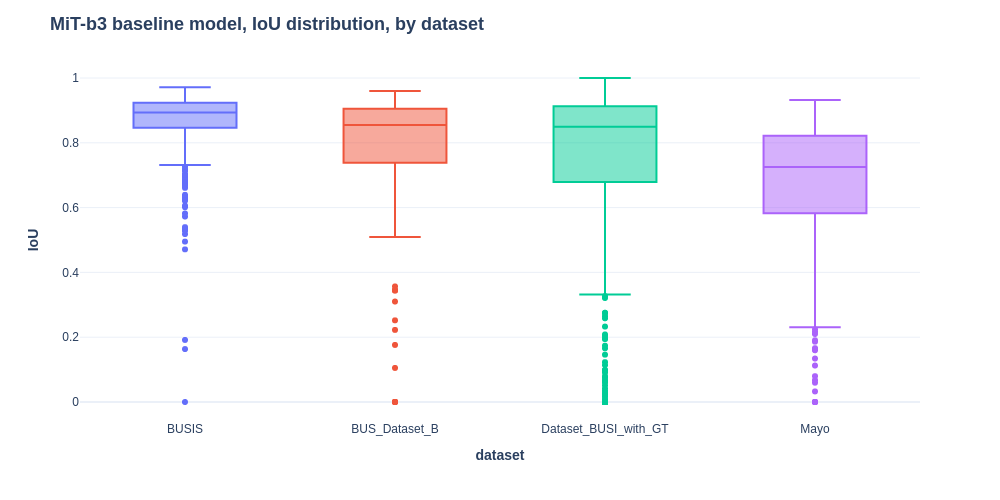

In [4]:
_ = px.box(
    data_frame=image_performance.query("model == 'mit-b3' and training == 'baseline'")[
        ["dataset", "iou"]
    ],
    x="dataset",
    color="dataset",
    y="iou",
    width=1000,
    height=500,
).update_layout(
    showlegend=False,
    title=dict(
        text="<b>MiT-b3 baseline model, IoU distribution, by dataset</b>",
        font=dict(size=18),
    ),
    template="plotly_white",
    xaxis_title="<b>dataset</b>",
    yaxis_title="<b>IoU</b>",
)
_.write_image("iou_mit-b3_datasets.png")
_.show("png")


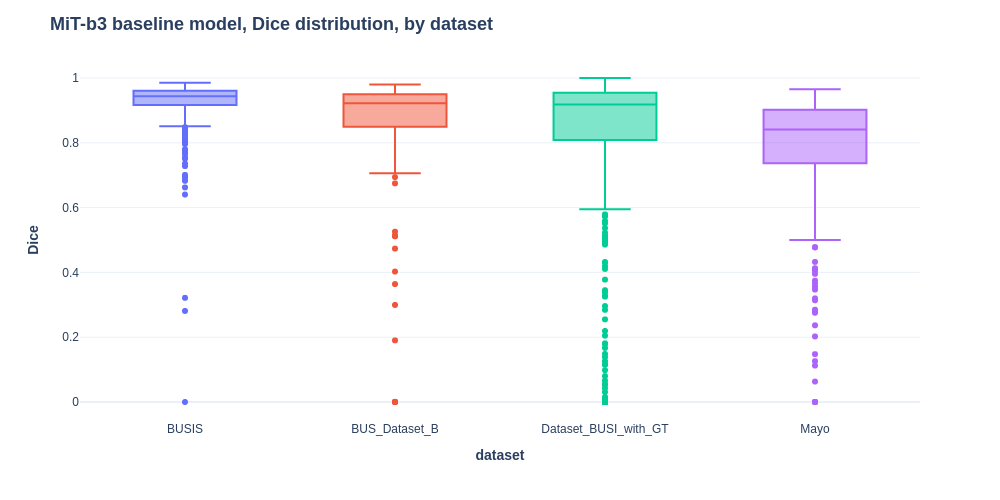

In [5]:
_ = px.box(
    data_frame=image_performance.query("model == 'mit-b3' and training == 'baseline'")[
        ["dataset", "dice"]
    ],
    x="dataset",
    color="dataset",
    y="dice",
    width=1000,
    height=500,
).update_layout(
    showlegend=False,
    title=dict(
        text="<b>MiT-b3 baseline model, Dice distribution, by dataset</b>",
        font=dict(size=18),
    ),
    template="plotly_white",
    xaxis_title="<b>dataset</b>",
    yaxis_title="<b>Dice</b>",
)
_.write_image("dice_mit-b3_datasets.png")
_.show("png")


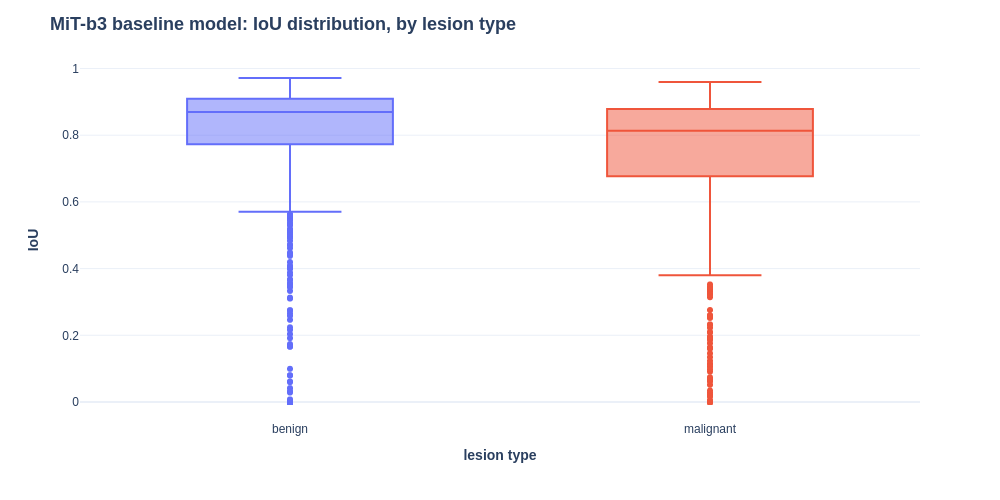

In [6]:
_ = px.box(
    data_frame=image_performance.query(
        "model == 'mit-b3' and training == 'baseline' and tumor != 'normal'"
    )[["tumor", "iou"]],
    x="tumor",
    color="tumor",
    y="iou",
    width=1000,
    height=500,
).update_layout(
    showlegend=False,
    title=dict(
        text="<b>MiT-b3 baseline model: IoU distribution, by lesion type</b>",
        font=dict(size=18),
    ),
    template="plotly_white",
    xaxis_title="<b>lesion type</b>",
    yaxis_title="<b>IoU</b>",
)
_.show("png")


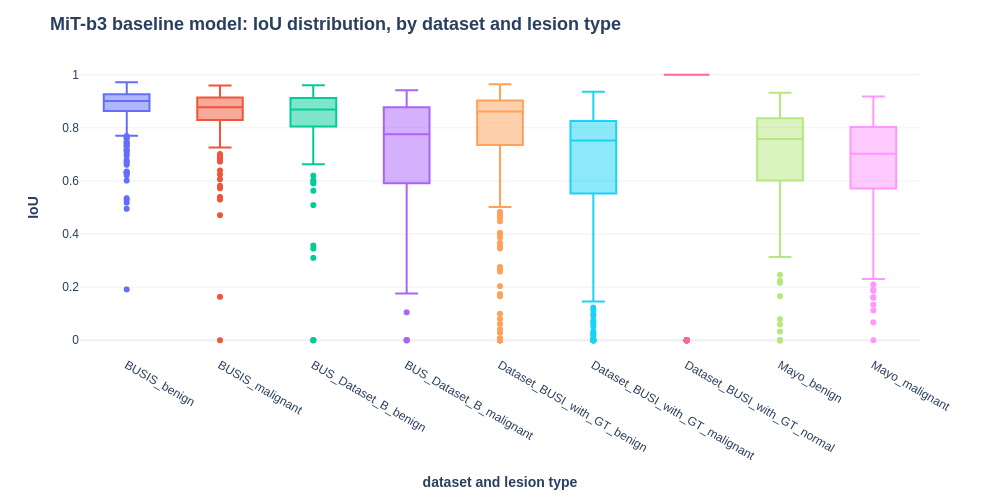

In [7]:
_ = px.box(
    data_frame=image_performance.query("model == 'mit-b3' and training == 'baseline'")[
        ["dataset_tumor", "iou"]
    ],
    x="dataset_tumor",
    color="dataset_tumor",
    y="iou",
    width=1000,
    height=500,
).update_layout(
    showlegend=False,
    title=dict(
        text="<b>MiT-b3 baseline model: IoU distribution, by dataset and lesion type</b>",
        font=dict(size=18),
    ),
    template="plotly_white",
    xaxis_title="<b>dataset and lesion type</b>",
    yaxis_title="<b>IoU</b>",
)
_.show("png")


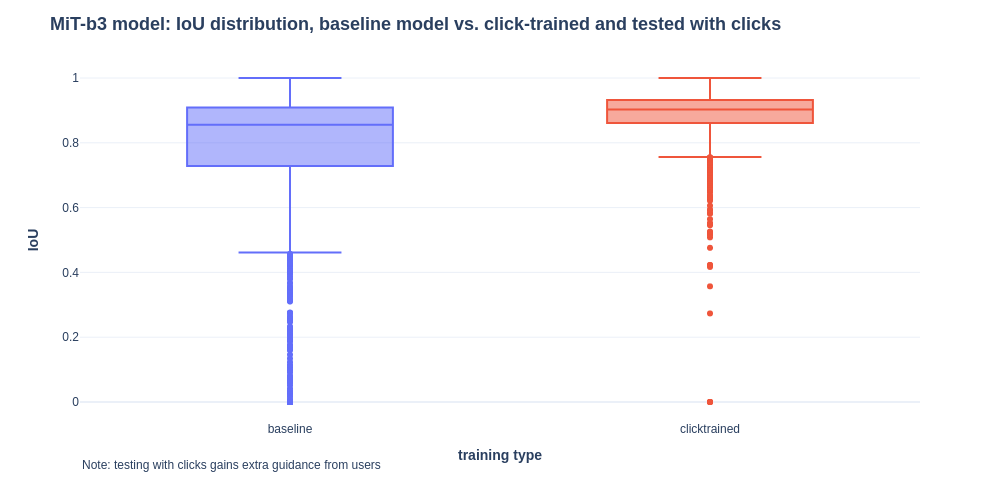

In [8]:
_ = (
    px.box(
        data_frame=image_performance.query(
            "model == 'mit-b3' and testing != 'without_clicks'"
        ),
        x="training",
        color="training",
        y="iou",
        width=1000,
        height=500,
    )
    .update_layout(
        showlegend=False,
        title=dict(
            text="<b>MiT-b3 model: IoU distribution, baseline model vs. click-trained and tested with clicks</b>",
            font=dict(size=18),
        ),
        template="plotly_white",
        xaxis_title="<b>training type</b>",
        yaxis_title="<b>IoU</b>",
    )
    .add_annotation(
        text="Note: testing with clicks gains extra guidance from users",
        showarrow=False,
        x=0,
        y=-0.15,
        xref="paper",
        yref="paper",
    )
)
_.write_image("iou_mit-b3_training.png")
_.show("png")
